## **Mount drive** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/MyDrive/ITU/ML/Assignment2

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/ITU/ML/Assignment2'
D:\ITU\sem2\ML\assignmnets\2


## **Unzip Dataset**

In [19]:
import zipfile
with zipfile.ZipFile('CelebA.zip', 'r') as zip_ref:
    zip_ref.extractall('CelebA')

with zipfile.ZipFile('CelebA/CelebA/Img/img_align_celeba.zip', 'r') as zip_ref:
    zip_ref.extractall('/CelebA/CelebA/Img')

## **Import Libraries**

In [42]:
import pandas as pd 
import os
import cv2

import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## **Preparing Dataset for task 1**

**Data Preprocessing: Selecting 120 unique identities**

In [16]:
# specify paths 
label_file = 'CelebA\Anno\identity_CelebA.txt'
img_dir = 'CelebA\Img\img_align_celeba\img_align_celeba'
output_dir = 'task1_data'

# load labels file
data= pd.read_csv(label_file, sep=' ', header=None, names=['img', 'id'])

# mean_value of images for each label
mean_count = data['id'].value_counts().mean()

# selecting 120 unique entries having examples more than mean_count
selected_ids = [id for id,count in data['id'].value_counts().items() if count>mean_count][0:120]

# selecting images of selected_ids and creating a new dataset for this task


os.makedirs(output_dir, exist_ok=True)
for i in selected_ids: 
    os.makedirs(os.path.join(output_dir, str(i)), exist_ok=True)

for i in selected_ids:
    # find imgs belonging to class i
    id_df = data.loc[data.id == i]

    # create image list
    img_list = id_df.img.to_list()
  
    for img in img_list:
        # reading img
        image = cv2.imread(os.path.join(img_dir,img))

        # saving image in the relevant directory
        cv2.imwrite(os.path.join(output_dir,str(i),img), image)

**Data Loading: Spliting into test train and validation**

In [44]:
def load_dataset(dataset_path,train_size, validation_size, test_size, batch_size):

    transform = transforms.Compose([#transforms.Grayscale(), 
                                         transforms.ToTensor(),
                                         #transforms.Resize((28,28)), 
                                         #transforms.Normalize(0,0.5)
                                         ])
    # read dataset
    dataset = datasets.ImageFolder(dataset_path, transform=transform)

    # specify sizes
    train_set_size = int(len(dataset) * train_size)
    test_set_size = int(len(dataset) * test_size)
    val_set_size = len(dataset) - train_set_size - test_set_size

    # split data
    train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_set_size,val_set_size,test_set_size])

    # create dataloader for each data (test,train,val)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    #return test_data
    return train_data_loader, val_data_loader, test_data_loader

In [45]:
train_data_loader, val_data_loader, test_data_loader =  load_dataset('task1_data',0.7,0.15,0.15, 16)

## **Creating Model**

In [46]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*218*178, 1000)
        self.fc2 = nn.Linear(1000, 800)
        self.fc3 = nn.Linear(800, 400)
        self.fc4 = nn.Linear(400, 120)


    def forward(self, x):
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# model
net = Net().to(device)

## Training Model

In [47]:
def train(epochs, train_data_loader, val_data_loader, loss_func, optimizer, learning_rate):
    train_step = len(train_data_loader)
    val_step = len(val_data_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs): # iterate over epochs
        t_loss = 0
        t_acc = 0 
        for i, data in enumerate(train_data_loader): # iterate over batches
            # get image and labels data is in tuple form (inputs, label)
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero-out gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            _, pred = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            t_acc += torch.sum(pred == labels)/len(labels)

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, epochs, i+1, train_step, loss.item()))
    
        v_loss = 0
        v_acc = 0
        for i, data in enumerate(val_data_loader): # iterate over batches
            # get image and labels data is in tuple form (inputs, label)
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, pred = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            v_loss += loss.item()
            v_acc += torch.sum(pred == labels)/len(labels)
     
        train_loss.append(t_loss/train_step)
        train_acc.append(t_acc/train_step)
        val_loss.append(v_loss/val_step)
        val_acc.append(v_acc/val_step)
        print ('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}' .format(epoch+1, epochs, train_loss[-1], val_loss[-1]))
    return train_loss, train_acc, val_loss, val_acc

In [48]:
# loss
criterion = nn.CrossEntropyLoss()


#optimizer
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#training
train_loss, train_acc, val_loss, val_acc= train(10, train_data_loader,  val_data_loader,criterion, optimizer, learning_rate)

Epoch [1/10], Step [10/160], Loss: 7.7904
Epoch [1/10], Step [20/160], Loss: 5.8091
Epoch [1/10], Step [30/160], Loss: 4.8286
Epoch [1/10], Step [40/160], Loss: 4.9111
Epoch [1/10], Step [50/160], Loss: 4.6708
Epoch [1/10], Step [60/160], Loss: 4.8174
Epoch [1/10], Step [70/160], Loss: 4.7620
Epoch [1/10], Step [80/160], Loss: 4.8048
Epoch [1/10], Step [90/160], Loss: 4.7713
Epoch [1/10], Step [100/160], Loss: 4.7931
Epoch [1/10], Step [110/160], Loss: 4.7874
Epoch [1/10], Step [120/160], Loss: 4.7479
Epoch [1/10], Step [130/160], Loss: 4.7445
Epoch [1/10], Step [140/160], Loss: 4.7575
Epoch [1/10], Step [150/160], Loss: 4.9909
Epoch [1/10], Step [160/160], Loss: 4.6293
Epoch [1/10], train_loss: 5.3475, val_loss: 4.8625
Epoch [2/10], Step [10/160], Loss: 4.6815
Epoch [2/10], Step [20/160], Loss: 4.8109
Epoch [2/10], Step [30/160], Loss: 4.7327
Epoch [2/10], Step [40/160], Loss: 4.6851
Epoch [2/10], Step [50/160], Loss: 4.8616
Epoch [2/10], Step [60/160], Loss: 4.7215
Epoch [2/10], Step

## **Save Model**

In [51]:
path = 'saved_models/task1/task1.pt'
torch.save(net.state_dict(), path)

np.save('saved_models/task1/train_loss', train_loss)
np.save('saved_models/task1/val_loss', val_loss)
np.save('saved_models/task1/train_acc', train_acc)
np.save('saved_models/task1/val_acc', val_acc)

## **Test Model**

In [53]:
dataiter = iter(test_data_loader)
images, test_labels = dataiter.next()
print(test_labels)

tensor([39, 16, 65, 70, 16, 75, 19, 62, 99, 25, 98, 99, 54, 10, 74, 32])


In [54]:
# load model
net.load_state_dict(torch.load(path))
test_out = net(images.to(device))
_, pred = torch.max(test_out, 1) 
pred

tensor([108,  91, 111,  96,  91,  38,  91,  96,  46,  38,  38,  38, 111,  46,
        108,  25])

In [60]:
# load model
path = 'saved_models/task1/epoch1/task1.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))

test_steps = len(test_data_loader)
t_acc=0
for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)


    # forward + backward + optimize
    outputs = net(inputs)
    _, pred = torch.max(outputs, 1)
    t_acc += torch.sum(pred == labels)/len(labels)

print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))

Test Accuracy: 0.0071


## **Visualize result**

Text(0.5, 1.0, 'training and validation loss')

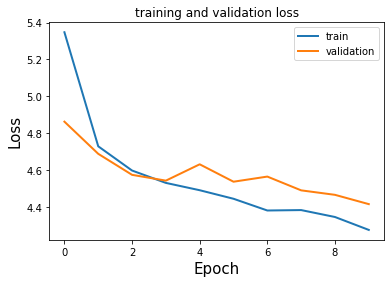

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.load('saved_models/task1/epoch1/train_loss.npy')
val_loss = np.load('saved_models/task1/epoch1/val_loss.npy')
plt.plot(train_loss, linewidth=2, label='train')
plt.plot(val_loss, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.title('training and validation loss')

val accuracy: 0.00859375
train accuracy: 0.00859375


Text(0.5, 1.0, 'training and validation Accuracy')

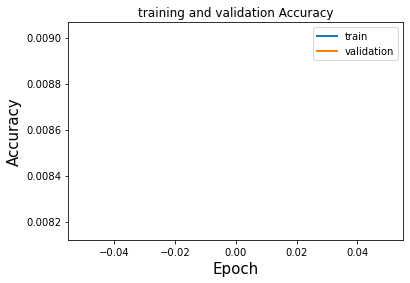

In [61]:
val_acc = np.load('saved_models/task1/epoch1/val_acc.npy')
train_acc = np.load('saved_models/task1/epoch1/train_acc.npy')
print('val accuracy:', val_acc[-1])
print('train accuracy:', train_acc[-1])
plt.plot(train_acc, linewidth=2, label='train')
plt.plot(val_acc, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title('training and validation Accuracy')